In [ ]:
!pip install imblearn

In [2]:
import os
import time
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import entropy
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 1) Import dataset, apply knowledge-based and criteria-based pruning

In [3]:
df = pd.read_csv('journal_bearing.csv')
header = ['speed', 'eccentricity', 'load', 'axial_pos', 'angular_pos', 'thickness', 'pressure']
df.columns = header
# Choose values of eccentricity between 0.3, 0.7 (Knowledge pruning)
df = df[df['eccentricity'].between(0.3, 0.7)]
# Remove the upcoming values that correspond to zero at any input 
zero_pressure_condition = (df['angular_pos']<-2.7) | (df['angular_pos']>1.37)
df = df[~zero_pressure_condition]
df = df.drop(columns=['eccentricity', 'thickness'])
df

ERROR! Session/line number was not unique in database. History logging moved to new session 2


,speed,load,axial_pos,angular_pos,pressure
2856028,209.439510,2379.22,0.000000,-2.686062,0.0
2856029,209.439510,2379.22,0.000000,-2.670354,0.0
2856030,209.439510,2379.22,0.000000,-2.654646,0.0
2856031,209.439510,2379.22,0.000000,-2.638938,0.0
2856032,209.439510,2379.22,0.000000,-2.623230,0.0
...,...,...,...,...,...
35495882,1047.197551,58880.20,0.038974,1.303761,0.0
35495883,1047.197551,58880.20,0.038974,1.319469,0.0
35495884,1047.197551,58880.20,0.038974,1.335177,0.0
35495885,1047.197551,58880.20,0.038974,1.350885,0.0


# 2) IS algorithms

## 2.1 Random Sampling

In [4]:
def random_IR(df, sampled_percent = 0.1):
    """
    (Instance selection -> Random Sampling)
    
    Args:
        df : dataframe (Full dataset)
        sampled_percent: Percentage of data sampled/retrieved

    Returns:
        Indices of Chosen points.
        
    """
    # Choose random rows from the DataFrame (90% reduction -> 10% of the dataset)
    random_rows_indices = df.sample(n=int(sampled_percent*df.shape[0]), random_state=42).index
    return random_rows_indices

## 2.2 Regression Autoencoder

In [5]:
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Reduce dataset using stratified sampling on embeddings

class IS_regression_autoencoder:
    def __init__(self, path, sampled_percent=0.1):
        self.path = path
        self.sampled_percent = sampled_percent
        
    def get_encoder_from_autoencoder(self, autoencoder, encoder_output_name):
        encoder_output = autoencoder.get_layer(encoder_output_name).output
        encoder = Model(inputs=autoencoder.input, outputs=encoder_output)
        return encoder

    def load_autoencoder(self):
        loaded_autoencoder = load_model(self.path)
        # Extract encoder architecture from the autoencoder
        input_layer = loaded_autoencoder.input

        # Use the function to extract the encoder
        self.loaded_encoder = self.get_encoder_from_autoencoder(loaded_autoencoder, encoder_output_name='encoder_output')
        
    def predict(self, X_train_normalized):
        # Reduce dimensions
        embeddings = self.loaded_encoder.predict(X_train_normalized)
        return embeddings

    def draw_embeddings(self):
        # Hexbin plot
        plt.hexbin(encoded_data[:,0], encoded_data[:,1], gridsize=50, cmap='Greys')
        plt.colorbar()
        plt.title("Hexbin Plot of 2D Representations")
        plt.show()
    
    def reduce_data_stratified_sampling(self, encoded_data, y):
        # First fit the data using KMeans clustering 
        kmeans = KMeans(n_clusters=3)
        clusters = kmeans.fit_predict(encoded_data)
        
        # Stratified sampling
        splits = StratifiedShuffleSplit(n_splits=1, test_size=self.sampled_percent, random_state=42)
        for train_index, sample_index in splits.split(encoded_data, clusters):
            sampled_data = encoded_data[sample_index]
            # Get the original indices from y's index
            original_sampled_indices = y.index[sample_index]
            sampled_clusters = clusters[sample_index]
        return original_sampled_indices

In [6]:
def Instance_Reduction(df_scaled, method='random', nn=2, sampled_percent=0.1):

    if method=='random':
        return df_scaled.loc[random_IR(df_scaled, sampled_percent)].sort_values(by=['speed'])
    
    elif method=='reg_autoencoder':
        model_path = 'models_reg_autoencoder/model_epoch_09.h5'
        reg_autoencoder = IS_regression_autoencoder(model_path, sampled_percent)  
        reg_autoencoder.load_autoencoder()
        X_train_normalized = df_scaled.drop(columns='pressure')
        y_train = df_scaled['pressure']
        encoded_data = reg_autoencoder.predict(X_train_normalized)
        reduced_subset_indices = reg_autoencoder.reduce_data_stratified_sampling(encoded_data, y_train)
        reduced_df = df_scaled.loc[reduced_subset_indices]
        return reduced_df
        
    elif method=='full':
        return df_scaled

## 3) Training (Applying 3 Folds of predefined splits)

### 3.1 reg_autoencoder and random sampling
### pruning percentages (80%, 20%)

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)


def build_model():
        # Setting the random seeds
        tf.random.set_seed(42)

        # Using "HeUniform" initialization and the seed ensures that every time we build the model, it gets initilazed with same weights
        model = keras.Sequential([ 
                keras.layers.Dense(512, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(64, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(32, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(1, kernel_initializer=keras.initializers.HeUniform(seed=42))
            ])
        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')
        return model

X_train = df.drop(columns=['pressure'])
y_train = df['pressure']

# Scale the features
scaler = StandardScaler()
# Use the scaler on the "whole dataset"
X_train_normalized = scaler.fit_transform(X_train)

df_train_scaled = pd.DataFrame(X_train_normalized, columns=X_train.columns)
df_train_scaled['pressure'] = y_train.values

# Speeds for splitting. Every list is a separate validation fold
# Every split is approximately 24% validation
split_speeds = [
    [314.1592653589793, 523.5987755982989, 680.6784082777885, 994.8376736367678],
    [261.79938779914943, 575.9586531581286, 733.0382858376183, 837.7580409572781],
    [418.8790204786391, 628.3185307179587, 890.117918517108, 942.477796076938]  
]

#Example: [-1, -1, 0, 0, 1], (-1 -> training set), (0, first validation fold), (1, second validaiton fold)
# Initialize all the array as training set, later the validation will be chosen
val_fold = np.full(X_train.shape[0], -1)  

# Assign fold numbers based on the condition
for i, speeds in enumerate(split_speeds):
    condition = X_train['speed'].isin(speeds)
    # Assign fold number
    val_fold[condition] = i

# Use PredefinedSplit with the val_fold
ps = PredefinedSplit(val_fold)
# Stores MAE for each instance reduction algorithm
results = {}  

# "full", "reg_autoencoder", 'random'
red_types = ['reg_autoencoder', 'random']
sampled_percent = [0.8, 0.2]

# loop for every sampled_percent for every algorithm. Every algorithm will train on 3 train/test fold.
for percent in sampled_percent:
    for reduction_type in red_types:
        # store mae for every fold
        maes = []
        for split_num, (train_idx, val_idx) in enumerate(ps.split()):
            # Assign train and validation folds using the indices of the predefined split
            X_train_fold = X_train_normalized[train_idx]
            y_train_fold = y_train.iloc[train_idx].values
            X_val_fold = X_train_normalized[val_idx]
            y_val_fold = y_train.iloc[val_idx].values      
            
            df_train_fold = pd.DataFrame(X_train_fold, columns=X_train.columns)
            df_train_fold['pressure'] = y_train_fold      
            start = time.time()
            shape_before = df_train_fold.shape[0]
            # Apply instance reduction algorithm to retrieve the reduced data
            filtered_scaled_df = Instance_Reduction(df_train_fold, reduction_type, nn=2, sampled_percent=percent)  
            X_train_reduced = filtered_scaled_df.drop(columns='pressure')
            y_train_reduced = filtered_scaled_df['pressure']
            
            print(f'Method used: {reduction_type} with test percent: {percent}. Time elapsed: {round(time.time()-start, 2)} seconds')
            print(f"Reduced from {shape_before} instances to {filtered_scaled_df.shape[0]}")
            print(f"Reduction percentage: {round(((1-(filtered_scaled_df.shape[0]/shape_before))*100), 1)}%")

            save_dir = f'models_{reduction_type}_{int(percent*100)}_pruning_modification'
            os.makedirs(save_dir, exist_ok=True)

            filename = (f"model_{percent*100}percent_split_{split_num+1}_"
                        f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}__"
                        f"epoch_{{epoch:02d}}__val_loss_{{val_loss:.4f}}.h5")
            
            # ModelCheckpoint callback to save the best validation models
            checkpoint = ModelCheckpoint(os.path.join(save_dir, filename), monitor='val_loss', save_best_only=True)

            model = build_model()
            history = model.fit(X_train_reduced, y_train_reduced, epochs=50, batch_size=256, 
                                validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint])
            
            # Save the history in logs directory. This saves the history to retrieve the losses when evaluating and drawing graphs
            os.makedirs('logs_pruning_modification', exist_ok=True)
            file_name = f"logs/history_{reduction_type}_{percent*100}percent.pkl"
            with open(file_name, 'wb') as file:
                pickle.dump(history.history, file)
            
            best_val_mae = min(history.history['val_loss'])
            maes.append(best_val_mae)

        # Store the MAE scores in the results dictionary for the current reduction type and test percent
        key = f"{reduction_type}_{int(percent*100)}percent"
        results[key] = maes

with open('results_pruning_modification.pkl', 'wb') as file:
    pickle.dump(results, file)

# Print the best validation MAE for every fold.
for key, values in results.items():
    avg_mae = np.mean(values)
    std_mae = np.std(values)
    print(f"Reduction type: {key}")
    for i, mae in enumerate(values):
        print(f"    Fold {i+1} MAE: {mae:.4f}")
    print(f"    Average MAE: {avg_mae:.4f}")
    print(f"    Standard Deviation: {std_mae:.4f}")

2023-09-01 01:17:16.577410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


505050/505050 [==============================] - 457s 900us/step


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.8. Time elapsed: 743.74 seconds
Reduced from 16161600 instances to 12929280
Reduction percentage: 20.0%
Epoch 1/50
50505/50505 [==============================] - 145s 3ms/step - loss: 38643.1328 - val_loss: 16341.7852
Epoch 2/50
   67/50505 [..............................] - ETA: 1:57 - loss: 14810.9268

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 142s 3ms/step - loss: 14682.4678 - val_loss: 14440.8906
Epoch 3/50
50505/50505 [==============================] - 142s 3ms/step - loss: 13696.7734 - val_loss: 12993.5859
Epoch 4/50
50505/50505 [==============================] - 142s 3ms/step - loss: 13170.8574 - val_loss: 13375.1504
Epoch 5/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12826.7295 - val_loss: 13350.1084
Epoch 6/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12517.9756 - val_loss: 11459.5879
Epoch 7/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12273.3867 - val_loss: 10633.7412
Epoch 8/50
50505/50505 [==============================] - 142s 3ms/step - loss: 11985.3887 - val_loss: 12392.4902
Epoch 9/50
50505/50505 [==============================] - 142s 3ms/step - loss: 11809.7734 - val_loss: 10622.4609
Epoch 10/50
50505/50505 [==============================] - 142s 3ms/step - loss: 11608.5137 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.8. Time elapsed: 750.29 seconds
Reduced from 16161600 instances to 12929280
Reduction percentage: 20.0%
Epoch 1/50
50505/50505 [==============================] - 146s 3ms/step - loss: 39119.2773 - val_loss: 15276.8662
Epoch 2/50
   67/50505 [..............................] - ETA: 1:56 - loss: 15639.1562

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 144s 3ms/step - loss: 14724.9912 - val_loss: 11863.1748
Epoch 3/50
50505/50505 [==============================] - 145s 3ms/step - loss: 13779.2129 - val_loss: 14363.8818
Epoch 4/50
50505/50505 [==============================] - 145s 3ms/step - loss: 13247.7617 - val_loss: 10598.0459
Epoch 5/50
50505/50505 [==============================] - 145s 3ms/step - loss: 12860.0928 - val_loss: 12658.1426
Epoch 6/50
50505/50505 [==============================] - 145s 3ms/step - loss: 12494.5752 - val_loss: 11780.9766
Epoch 7/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12252.7314 - val_loss: 11266.1807
Epoch 8/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12031.4219 - val_loss: 10467.3477
Epoch 9/50
50505/50505 [==============================] - 145s 3ms/step - loss: 11848.1289 - val_loss: 10697.0156
Epoch 10/50
50505/50505 [==============================] - 145s 3ms/step - loss: 11691.1699 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.8. Time elapsed: 724.9 seconds
Reduced from 16161600 instances to 12929280
Reduction percentage: 20.0%
Epoch 1/50
50505/50505 [==============================] - 145s 3ms/step - loss: 39772.7070 - val_loss: 16471.0547
Epoch 2/50
   67/50505 [..............................] - ETA: 1:56 - loss: 15859.2236

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 144s 3ms/step - loss: 15026.6387 - val_loss: 14895.3184
Epoch 3/50
50505/50505 [==============================] - 143s 3ms/step - loss: 13908.3301 - val_loss: 14588.7480
Epoch 4/50
50505/50505 [==============================] - 143s 3ms/step - loss: 13244.9092 - val_loss: 14398.5059
Epoch 5/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12852.4473 - val_loss: 12867.8965
Epoch 6/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12528.7324 - val_loss: 21501.3574
Epoch 7/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12275.8789 - val_loss: 12784.1924
Epoch 8/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12080.8447 - val_loss: 15032.0781
Epoch 9/50
50505/50505 [==============================] - 144s 3ms/step - loss: 11867.1689 - val_loss: 13676.4785
Epoch 10/50
50505/50505 [==============================] - 143s 3ms/step - loss: 11692.6777 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 142s 3ms/step - loss: 14995.2783 - val_loss: 15192.7119
Epoch 3/50
50505/50505 [==============================] - 142s 3ms/step - loss: 13938.1113 - val_loss: 15756.8506
Epoch 4/50
50505/50505 [==============================] - 142s 3ms/step - loss: 13324.7275 - val_loss: 12917.8096
Epoch 5/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12959.2900 - val_loss: 14464.0840
Epoch 6/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12670.2070 - val_loss: 11184.7812
Epoch 7/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12409.2441 - val_loss: 13152.6074
Epoch 8/50
50505/50505 [==============================] - 142s 3ms/step - loss: 12202.6221 - val_loss: 13780.4668
Epoch 9/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12004.3125 - val_loss: 11446.0986
Epoch 10/50
50505/50505 [==============================] - 143s 3ms/step - loss: 11807.1543 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 144s 3ms/step - loss: 15291.2021 - val_loss: 15435.0146
Epoch 3/50
50505/50505 [==============================] - 143s 3ms/step - loss: 14208.0225 - val_loss: 11716.5645
Epoch 4/50
50505/50505 [==============================] - 144s 3ms/step - loss: 13617.8633 - val_loss: 13110.2324
Epoch 5/50
50505/50505 [==============================] - 143s 3ms/step - loss: 13249.5830 - val_loss: 12612.2764
Epoch 6/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12961.6074 - val_loss: 11055.9023
Epoch 7/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12707.3369 - val_loss: 10927.3857
Epoch 8/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12492.4316 - val_loss: 11572.8467
Epoch 9/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12216.0771 - val_loss: 10513.1982
Epoch 10/50
50505/50505 [==============================] - 143s 3ms/step - loss: 12081.5439 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50505/50505 [==============================] - 144s 3ms/step - loss: 15138.3398 - val_loss: 15194.4717
Epoch 3/50
50505/50505 [==============================] - 144s 3ms/step - loss: 13808.4199 - val_loss: 14693.5234
Epoch 4/50
50505/50505 [==============================] - 144s 3ms/step - loss: 13125.4238 - val_loss: 14817.1006
Epoch 5/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12627.1396 - val_loss: 15515.2852
Epoch 6/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12333.1934 - val_loss: 13809.5762
Epoch 7/50
50505/50505 [==============================] - 144s 3ms/step - loss: 12062.7617 - val_loss: 15651.8447
Epoch 8/50
50505/50505 [==============================] - 144s 3ms/step - loss: 11866.7490 - val_loss: 12771.0254
Epoch 9/50
50505/50505 [==============================] - 144s 3ms/step - loss: 11633.9482 - val_loss: 12907.6504
Epoch 10/50
50505/50505 [==============================] - 143s 3ms/step - loss: 11479.0166 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.2. Time elapsed: 750.14 seconds
Reduced from 16161600 instances to 3232320
Reduction percentage: 80.0%
Epoch 1/50
12627/12627 [==============================] - 57s 4ms/step - loss: 105037.3125 - val_loss: 19719.3613
Epoch 2/50
   66/12627 [..............................] - ETA: 29s - loss: 20096.0898

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 18180.5508 - val_loss: 22516.5137
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16478.7656 - val_loss: 18816.8125
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15630.7139 - val_loss: 23069.2090
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15023.3916 - val_loss: 14501.3623
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14569.2422 - val_loss: 19181.4688
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14373.0703 - val_loss: 14094.3027
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14044.6416 - val_loss: 15557.8379
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13851.7705 - val_loss: 21254.4023
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13670.0186 - val_loss: 1643

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.2. Time elapsed: 745.47 seconds
Reduced from 16161600 instances to 3232320
Reduction percentage: 80.0%
Epoch 1/50
12627/12627 [==============================] - 57s 4ms/step - loss: 106757.3984 - val_loss: 18086.4766
Epoch 2/50
   66/12627 [..............................] - ETA: 29s - loss: 19730.1426

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 18861.8652 - val_loss: 20100.4492
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16678.7363 - val_loss: 15272.3916
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15742.9453 - val_loss: 24009.8574
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15216.8008 - val_loss: 12855.7627
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14754.9746 - val_loss: 12522.6152
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14424.0771 - val_loss: 12804.7236
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14211.4248 - val_loss: 13837.9365
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13998.2246 - val_loss: 12826.0615
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13860.0254 - val_loss: 1174

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder with test percent: 0.2. Time elapsed: 734.29 seconds
Reduced from 16161600 instances to 3232320
Reduction percentage: 80.0%
Epoch 1/50
12627/12627 [==============================] - 58s 4ms/step - loss: 104843.6406 - val_loss: 23563.7715
Epoch 2/50
   64/12627 [..............................] - ETA: 30s - loss: 19715.4824

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 18677.6133 - val_loss: 19492.9277
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16594.0703 - val_loss: 23537.2188
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15571.0029 - val_loss: 15975.6719
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15027.2939 - val_loss: 17947.2676
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14574.8750 - val_loss: 18607.0977
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14271.6289 - val_loss: 21658.1504
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14040.5771 - val_loss: 15084.8018
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13790.5967 - val_loss: 16832.9336
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13491.4932 - val_loss: 1605

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 18330.6855 - val_loss: 17264.1777
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16656.5664 - val_loss: 21440.3438
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15783.4951 - val_loss: 13685.8789
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15329.1016 - val_loss: 14385.2559
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14813.4180 - val_loss: 16056.8193
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14441.3789 - val_loss: 13138.1328
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14274.4746 - val_loss: 13776.8105
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14076.8496 - val_loss: 15475.0996
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13836.5342 - val_loss: 1414

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 19312.2305 - val_loss: 14056.5449
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 17265.1855 - val_loss: 14811.6426
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16324.8496 - val_loss: 14466.8438
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15639.6992 - val_loss: 14087.2285
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15127.8809 - val_loss: 14210.5371
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14794.6533 - val_loss: 12890.6309
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14483.0322 - val_loss: 13333.6455
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14195.8262 - val_loss: 11885.7285
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13991.2441 - val_loss: 1775

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12627/12627 [==============================] - 56s 4ms/step - loss: 18346.4746 - val_loss: 18073.2012
Epoch 3/50
12627/12627 [==============================] - 56s 4ms/step - loss: 16204.1660 - val_loss: 17565.3867
Epoch 4/50
12627/12627 [==============================] - 56s 4ms/step - loss: 15273.9062 - val_loss: 16933.8320
Epoch 5/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14505.6602 - val_loss: 14885.3604
Epoch 6/50
12627/12627 [==============================] - 56s 4ms/step - loss: 14226.8447 - val_loss: 15282.8809
Epoch 7/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13788.9629 - val_loss: 16465.2422
Epoch 8/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13487.3613 - val_loss: 21536.5664
Epoch 9/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13202.8271 - val_loss: 15836.0068
Epoch 10/50
12627/12627 [==============================] - 56s 4ms/step - loss: 13028.8467 - val_loss: 2737

### 3.2 Full dataset 

In [7]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)


def build_model():
        # Setting the random seeds
        tf.random.set_seed(42)

        #Using "HeUniform" initialization and the seed ensures that every time we build the model, it gets initilazed with same weights
        model = keras.Sequential([ 
                keras.layers.Dense(512, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(64, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(32, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(1, kernel_initializer=keras.initializers.HeUniform(seed=42))
            ])
        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')
        return model

X_train = df.drop(columns=['pressure'])
y_train = df['pressure']

# Scale the features
scaler = StandardScaler()
# Use the scaler on the "whole dataset"
X_train_normalized = scaler.fit_transform(X_train)

df_train_scaled = pd.DataFrame(X_train_normalized, columns=X_train.columns)
df_train_scaled['pressure'] = y_train.values

# Speeds for splitting. Every list is a separate validation fold
# Every split is approximately 24% validation
split_speeds = [
    [314.1592653589793, 523.5987755982989, 680.6784082777885, 994.8376736367678],
    [261.79938779914943, 575.9586531581286, 733.0382858376183, 837.7580409572781],
    [418.8790204786391, 628.3185307179587, 890.117918517108, 942.477796076938]
    
]

#Example: [-1, -1, 0, 0, 1], (-1 -> training set), (0, first validation fold), (1, second validaiton fold)
# Initialize all the array as training set, later the validation will be chosen
val_fold = np.full(X_train.shape[0], -1)

# Assign fold numbers based on the condition
for i, speeds in enumerate(split_speeds):
    condition = X_train['speed'].isin(speeds)
    # Assigning the fold number
    val_fold[condition] = i

# Use PredefinedSplit with the val_fold
ps = PredefinedSplit(val_fold)
# Stores MAE for each instance reduction algorithm
results = {}  

# "full", "reg_autoencoder", "random"
red_types = ['full']
sampled_percent = [1]

# loop for every sampled_percent for every algorithm. Every algorithm will train on 3 train/test fold.
for percent in sampled_percent:
    for reduction_type in red_types:
        # store mae for every fold
        maes = []  
        for split_num, (train_idx, val_idx) in enumerate(ps.split()):
            # Assign train and validation folds using the indices of the predefined split
            X_train_fold = X_train_normalized[train_idx]
            y_train_fold = y_train.iloc[train_idx].values
            X_val_fold = X_train_normalized[val_idx]
            y_val_fold = y_train.iloc[val_idx].values      
            
            df_train_fold = pd.DataFrame(X_train_fold, columns=X_train.columns)
            df_train_fold['pressure'] = y_train_fold      
            start = time.time()
            shape_before = df_train_fold.shape[0]
            # Apply instance reduction algorithm to retrieve the reduced data
            filtered_scaled_df = Instance_Reduction(df_train_fold, reduction_type, nn=2, sampled_percent=percent)  
            X_train_reduced = filtered_scaled_df.drop(columns='pressure')
            y_train_reduced = filtered_scaled_df['pressure']
            
            print(f'Method used: {reduction_type} with test percent: {percent}. Time elapsed: {round(time.time()-start, 2)} seconds')
            print(f"Reduced from {shape_before} instances to {filtered_scaled_df.shape[0]}")
            print(f"Reduction percentage: {round(((1-(filtered_scaled_df.shape[0]/shape_before))*100), 1)}%")

            save_dir = f'models_{reduction_type}_{int(percent*100)}_pruning_modification'
            os.makedirs(save_dir, exist_ok=True)

            filename = (f"model_{percent*100}percent_split_{split_num+1}_"
                        f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}__"
                        f"epoch_{{epoch:02d}}__val_loss_{{val_loss:.4f}}.h5")
            
            # ModelCheckpoint callback to save the best validation models
            checkpoint = ModelCheckpoint(os.path.join(save_dir, filename), monitor='val_loss', save_best_only=True)

            model = build_model()
            history = model.fit(X_train_reduced, y_train_reduced, epochs=50, batch_size=256, 
                                validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint])
            
            # Save the history in logs directory. This saves the history to retrieve the losses when evaluating and drawing graphs
            os.makedirs('logs_pruning_modification', exist_ok=True)
            file_name = f"logs/history_{reduction_type}_{percent*100}percent_{split_num}.pkl"
            with open(file_name, 'wb') as file:
                pickle.dump(history.history, file)
            
            best_val_mae = min(history.history['val_loss'])
            maes.append(best_val_mae)

        # Store the MAE scores in the results dictionary for the current reduction type and test percent
        key = f"{reduction_type}_{int(percent*100)}percent_{split_num+1}"
        results[key] = maes

with open('results_pruning_modification.pkl', 'wb') as file:
    pickle.dump(results, file)

# Print the best validation MAE for every fold
for key, values in results.items():
    avg_mae = np.mean(values)
    std_mae = np.std(values)
    print(f"Reduction type: {key}")
    for i, mae in enumerate(values):
        print(f"    Fold {i+1} MAE: {mae:.4f}")
    print(f"    Average MAE: {avg_mae:.4f}")
    print(f"    Standard Deviation: {std_mae:.4f}")

Method used: full with test percent: 1. Time elapsed: 0.18 seconds
Reduced from 16161600 instances to 16161600
Reduction percentage: 0.0%


2023-09-06 02:34:08.086791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
63114/63132 [============================>.] - ETA: 0s - loss: 34807.6758

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63132/63132 [==============================] - 155s 2ms/step - loss: 34802.1133 - val_loss: 15239.8447
Epoch 2/50
63132/63132 [==============================] - 151s 2ms/step - loss: 14037.0371 - val_loss: 13349.5117
Epoch 3/50
63132/63132 [==============================] - 152s 2ms/step - loss: 13129.3506 - val_loss: 12406.3516
Epoch 4/50
63132/63132 [==============================] - 152s 2ms/step - loss: 12648.4316 - val_loss: 15170.1182
Epoch 5/50
63132/63132 [==============================] - 152s 2ms/step - loss: 12323.9512 - val_loss: 11844.2949
Epoch 6/50
63132/63132 [==============================] - 152s 2ms/step - loss: 12064.4307 - val_loss: 12257.5029
Epoch 7/50
63132/63132 [==============================] - 152s 2ms/step - loss: 11831.9482 - val_loss: 12094.2959
Epoch 8/50
63132/63132 [==============================] - 151s 2ms/step - loss: 11598.3174 - val_loss: 12367.5742
Epoch 9/50
63132/63132 [==============================] - 152s 2ms/step - loss: 11421.7637 - val_lo

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63132/63132 [==============================] - 153s 2ms/step - loss: 14512.8496 - val_loss: 11293.5557
Epoch 3/50
63132/63132 [==============================] - 153s 2ms/step - loss: 13549.5195 - val_loss: 12166.5605
Epoch 4/50
63132/63132 [==============================] - 153s 2ms/step - loss: 13032.9199 - val_loss: 12096.1582
Epoch 5/50
63132/63132 [==============================] - 153s 2ms/step - loss: 12648.7920 - val_loss: 12708.7334
Epoch 6/50
63132/63132 [==============================] - 152s 2ms/step - loss: 12364.9805 - val_loss: 11785.1729
Epoch 7/50
63132/63132 [==============================] - 153s 2ms/step - loss: 12113.4883 - val_loss: 11240.3838
Epoch 8/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11922.9561 - val_loss: 10886.0166
Epoch 9/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11759.1006 - val_loss: 10403.8018
Epoch 10/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11624.6562 - val_l

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63132/63132 [==============================] - 153s 2ms/step - loss: 13612.8350 - val_loss: 13681.8076
Epoch 3/50
63132/63132 [==============================] - 153s 2ms/step - loss: 12788.9424 - val_loss: 14900.6445
Epoch 4/50
63132/63132 [==============================] - 153s 2ms/step - loss: 12277.8252 - val_loss: 14663.7803
Epoch 5/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11920.7305 - val_loss: 13717.9326
Epoch 6/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11618.3154 - val_loss: 16044.2285
Epoch 7/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11406.2734 - val_loss: 12661.7061
Epoch 8/50
63132/63132 [==============================] - 152s 2ms/step - loss: 11215.8379 - val_loss: 14714.1045
Epoch 9/50
63132/63132 [==============================] - 153s 2ms/step - loss: 11076.3691 - val_loss: 12670.2607
Epoch 10/50
63132/63132 [==============================] - 153s 2ms/step - loss: 10963.1592 - val_l

## 4) Evaluation
### 4.1 Validation

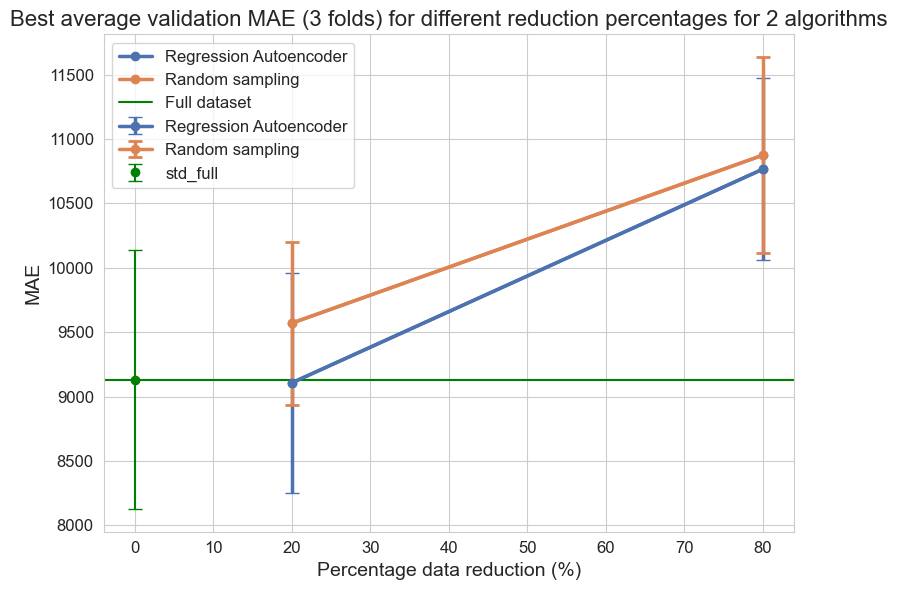

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the seaborn style
sns.set_style("whitegrid")

# x-values
reduction_percent = [20, 80]

# Values retrieved from section 3 
reg_autoencoder_20 = np.array([8784.4395, 8257.9688, 10279.1895])
random_20 = np.array([9532.3340, 8815.5322, 10363.3477])
reg_autoencoder_80 = np.array([10408.2979, 10135.6523, 11750.3789])
random_80 = np.array([10916.5205, 9918.9395, 11785.0674])
full = np.array([8345.7578, 8499.4131, 10552.2275])

# Mean y-values for each reduction percent
y_autoencoder_mean = np.array([np.mean(reg_autoencoder_20), np.mean(reg_autoencoder_80)])
y_random_mean = np.array([np.mean(random_20), np.mean(random_80)])
y_full_mean = np.mean(full)

# std values for y
std_autoencoder = [np.std(reg_autoencoder_20), np.std(reg_autoencoder_80)]
std_random = [np.std(random_20), np.std(random_80)]
std_full = np.std(full)

plt.figure(figsize=(8, 6))

# Plotting the lines
plt.plot(reduction_percent, y_autoencoder_mean, '-o', label='Regression Autoencoder', color=sns.color_palette("deep")[0], linewidth=2.5)
plt.errorbar(reduction_percent, y_autoencoder_mean, yerr=std_autoencoder, fmt='-o', label='Regression Autoencoder', color=sns.color_palette("deep")[0], linewidth=2.5, capsize=5)
plt.plot(reduction_percent, y_random_mean, '-o', label='Random sampling', color=sns.color_palette("deep")[1], linewidth=2.5)
plt.errorbar(reduction_percent, y_random_mean, yerr=std_random, fmt='-o', label='Random sampling', color=sns.color_palette("deep")[1], linewidth=2.5, capsize=5, capthick=2)

# Horizontal line for full dataset
plt.axhline(y=y_full_mean, color='green', linestyle='-', label='Full dataset')
plt.errorbar(0, y_full_mean, yerr=std_full, color='green', fmt='o', label='std_full', capsize=5)
plt.xlabel('Percentage data reduction (%)', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Best average validation MAE (3 folds) for different reduction percentages for 2 algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("../Images/percentage_reduction_3folds.png", dpi=300, bbox_inches='tight') 
plt.show()


### 4.2 Training

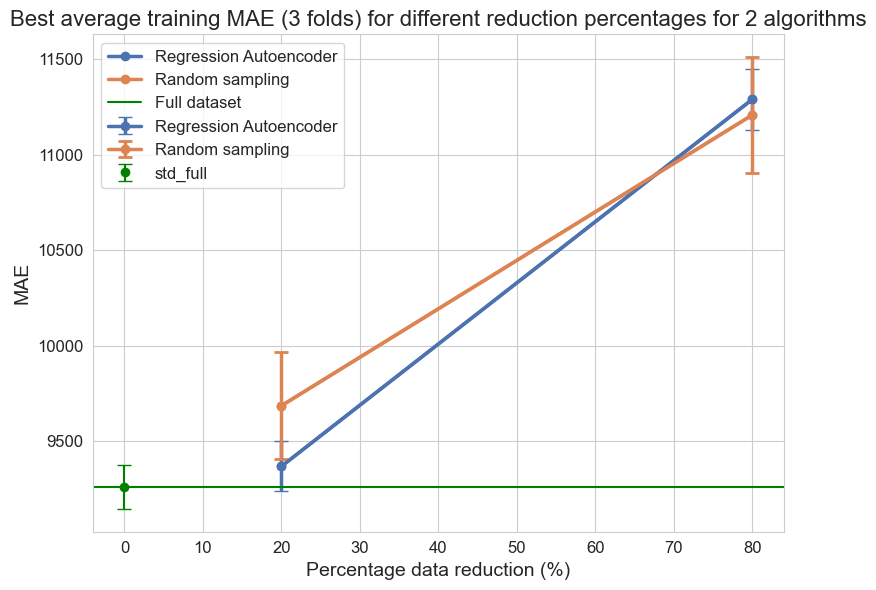

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# Reduction percentages
reduction_percent = [20, 80]

# Values retrieved from section 3 
reg_autoencoder_20 = np.array([9484.2051, 9438.0186, 9185.0596])
random_20 = np.array([10043.2510, 9661.1387, 9355.3906])
reg_autoencoder_80 = np.array([11368.4551, 11431.4453, 11070.0371])
random_80 = np.array([11345.5039, 11492.1826, 10786.8350])
full = np.array([9128.1045, 9409.0938, 9244.6240])

# Mean y-values for each reduction percent
y_autoencoder_mean = np.array([np.mean(reg_autoencoder_20), np.mean(reg_autoencoder_80)])
y_random_mean = np.array([np.mean(random_20), np.mean(random_80)])
full_mean = np.mean(full)

# std values for y
std_autoencoder = [np.std(reg_autoencoder_20), np.std(reg_autoencoder_80)]
std_random = [np.std(random_20), np.std(random_80)]
std_full = np.std(full)

plt.figure(figsize=(8, 6))

# Plotting the lines
plt.plot(reduction_percent, y_autoencoder_mean, '-o', label='Regression Autoencoder', color=sns.color_palette("deep")[0], linewidth=2.5)
plt.errorbar(reduction_percent, y_autoencoder_mean, yerr=std_autoencoder, fmt='-o', label='Regression Autoencoder', color=sns.color_palette("deep")[0], linewidth=2.5, capsize=5)
plt.plot(reduction_percent, y_random_mean, '-o', label='Random sampling', color=sns.color_palette("deep")[1], linewidth=2.5)
plt.errorbar(reduction_percent, y_random_mean, yerr=std_random, fmt='-o', label='Random sampling', color=sns.color_palette("deep")[1], linewidth=2.5, capsize=5, capthick=2)


# Constant horizontal line for full dataset
plt.axhline(y=np.mean(full), color='green', linestyle='-', label='Full dataset')
plt.errorbar(0, np.mean(full), yerr=std_full, color='green', fmt='o', label='std_full', capsize=5)

# Adding labels, title, and legend
plt.xlabel('Percentage data reduction (%)', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.title('Best average training MAE (3 folds) for different reduction percentages for 2 algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("../Images/percentage_reduction_training_3folds.png", dpi=300, bbox_inches='tight') 
plt.show()
